In [10]:
import sys
import torch
import numpy as np 
import matplotlib.pyplot as plt
import yaml
import gc

import neuralop

import evaluation_metrics as em

config = yaml.safe_load(open("ks_config.yaml")) # select the config file

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
test_data_path = "/scratch/julian/neuralop/pygen_200_512_2000_20_201.06.pth"

In [11]:
model = torch.load(config["default"]["save_model_path"]).to(device)
model_full = torch.load("/scratch/julian/neuralop/ks_models/pygen_full_res.pth")

data = torch.load(test_data_path).to(torch.float32).cpu().permute(2, 1, 0)[:, :, 0:50]

/tmp/ipykernel_3190749/1127948727.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(config["default"]["save_model_path"]).to(device)
/tmp/ipykernel_3190

In [13]:
model.eval()

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([128, 128, 65]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
          (1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(2, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
      (1): Conv1d(512, 1, kern

In [24]:
sample = data[::2, :, -2]
FNO_pred = sample.clone().to(device)
print(sample.shape)
print(FNO_pred.shape)

# start prediction after spin-up time of 500
for i in range(500, config["default"]["data"]["architecture"]["T"] - 1):
    FNO_pred[:, i+1] = model(FNO_pred[:, i].unsqueeze(0).unsqueeze(0))

torch.Size([256, 2000])
torch.Size([256, 2000])
torch.Size([256]) [[0.0, 1.0]]


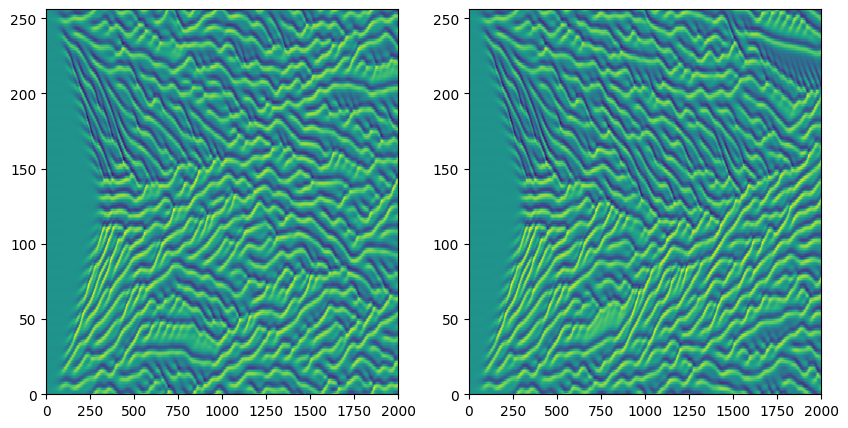

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(sample.cpu().detach().numpy())
ax[1].pcolormesh(FNO_pred.cpu().detach().numpy())

In [40]:
model(FNO_pred[:,500,:].unsqueeze(1))

tensor([[[ 1.1191,  0.9629, -0.2858,  ..., -0.9899, -1.5201, -0.4251]],

        [[-0.2783, -0.6832,  0.7321,  ..., -0.4685, -0.9692,  0.0598]],

        [[-1.2866, -1.9251,  1.6751,  ..., -0.0408, -0.5015,  0.7727]],

        ...,

        [[ 1.4600,  0.6634, -2.7483,  ..., -2.0236, -0.7373, -0.8574]],

        [[ 1.9488,  1.5225, -2.2647,  ..., -1.8221, -1.6754, -0.8322]],

        [[ 1.9455,  1.8180, -1.2879,  ..., -1.4664, -1.8794, -0.6959]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

In [26]:
sample = data[::2, :, :]
FNO_pred = sample.clone().to(device)
print(sample.shape)
print(FNO_pred.shape)
# start prediction after spin-up time of 500
for i in range(500, config["default"]["data"]["architecture"]["T"] - 1):
    #FNO_pred[:, i+1] = model(FNO_pred[:, i, :].unsqueeze(1).to(device)).squeeze(1).detach().cpu()
    FNO_pred[:, i+1] = model(FNO_pred[:, i, :].to(device)).detach().cpu()


torch.Size([256, 2000, 50])
torch.Size([256, 2000, 50])
torch.Size([]) [[0.0, 1.0]]


AssertionError: Error: inputs must have same number of dimensions

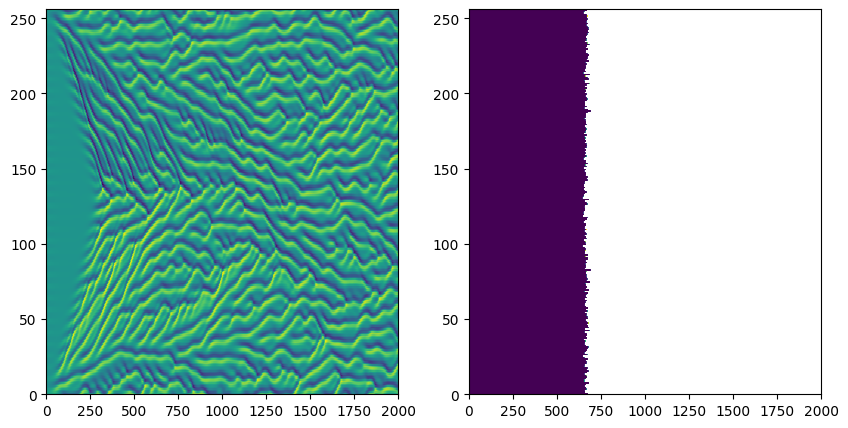

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(sample[:, :, 1].cpu().detach().numpy())
ax[1].pcolormesh(FNO_pred[:, :, 1].cpu().detach().numpy())

In [46]:
factor = config['default']['data']['coarsen_factor']

FNO_pred = data[:, :, :].clone()#.requires_grad_(False).to(device)

for i in range(500, config["default"]["data"]["architecture"]["T"] - 1):
    if i % 50 == 0:
        print(i)
        torch.cuda.empty_cache()    

    result = model(FNO_pred[:, i, :].unsqueeze(1).to(device)).squeeze(1).detach().cpu()

    FNO_pred[:, i+1] = result

    del result

500
torch.Size([50]) [[0.0, 1.0]]
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950


In [ ]:
# FNO_pred.shape


torch.Size([256, 2000, 50])

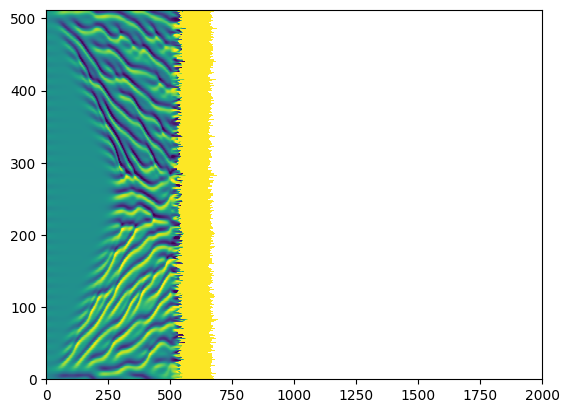

In [47]:
plt.pcolormesh(FNO_pred[:, :, 0].detach().cpu().numpy(), vmin = -3, vmax = 3)

In [ ]:
factor = config['default']['data']['coarsen_factor']

FNO_pred = data[:, :, :].clone().requires_grad_(False)

for i in range(500, config["default"]["data"]["architecture"]["T"] - 1):
    if i % 50 == 0:
        print(i)
        torch.cuda.empty_cache()    

    result = model_full(FNO_pred[:, i, :].unsqueeze(1).to(device)).squeeze(1).detach().cpu()

    FNO_pred[:, i+1, :] = result

    del result